# Exercises

In [3]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

### Data preparation

To better organize the workflow and manage the numerous datasets in this notebook, we have created a loop that iterates through the datasets stored in the folder assigned to our group. It loads each dataset into a DataFrame object and stores them in a list of DataFrames. This allows us to iterate over the list if we want to perform operations on all 10 datasets, avoiding the need to read the datasets repeatedly.

In [4]:
# List to hold all DataFrames
dataframes = []

# Iterate over files in the directory
for f in os.listdir('./ProjectDatasets/Team_7'):
    if f.endswith('.csv'):  # Check if it's a CSV file
        df = pd.read_csv(os.path.join('./ProjectDatasets/Team_7', f))
        df['Company'] = os.path.splitext(f)[0]  # Add a Company column using the filename (without extension)
        # Ensure the 'Date' column is parsed as datetime
        df['Date'] = pd.to_datetime(df['Date'])
        dataframes.append(df)

We define the columns that are numerical and relative to the stock price, so we can call this list when we need it to iterate through these columns to make transformations.

In [5]:
num_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

We have also created a single combined DataFrame in case it proves useful for any exercise.

In [6]:
merged_df = pd.concat(dataframes, ignore_index=True)
columns = ['Company'] + [col for col in merged_df.columns if col != 'Company']
dfm = merged_df[columns]

#### Missing data

In [7]:
results = []
company_names = []

for df in dataframes:
    company_name = df["Company"][0]
    company_names.append(company_name)
    total_rows = len(df)
    null_percentages = (df.isnull().sum() / total_rows) * 100
    
    result = {"Company": company_name}
    result.update(null_percentages.to_dict())
    results.append(result)

final_df = pd.DataFrame(results, index=company_names)
final_df = final_df.round(2)
final_df

,Company,Date,Open,High,Low,Close,Adj Close,Volume
SBUX,0.0,0.0,4.85,4.84,4.88,4.95,4.88,5.00
DPZ,0.0,0.0,4.83,4.87,4.89,4.87,4.91,4.99
MCD,0.0,0.0,4.90,4.88,4.89,4.81,4.89,5.00
LKNCY,0.0,0.0,4.81,4.96,4.89,4.67,4.89,4.96
QSR,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00
WEN,0.0,0.0,4.89,4.83,4.86,4.91,4.88,4.99
PZZA,0.0,0.0,4.76,4.83,4.88,4.90,4.86,5.00
YUM,0.0,0.0,4.90,4.87,4.88,4.94,4.87,5.01
BRK-A,0.0,0.0,4.89,4.85,4.93,4.87,4.85,5.00
DNUT,0.0,0.0,5.03,4.79,4.91,4.79,4.91,4.91


In [8]:
print(company_names)

['SBUX', 'DPZ', 'MCD', 'LKNCY', 'QSR', 'WEN', 'PZZA', 'YUM', 'BRK-A', 'DNUT']


As we can observe, there are around 5% missing observations for each variable in each company, except for the company QSR, which has no missing data.

#### Outliers

First, we need to identify whether there are outliers in the datasets and how they are distributed. To do this, we use boxplots for each variable and each company.

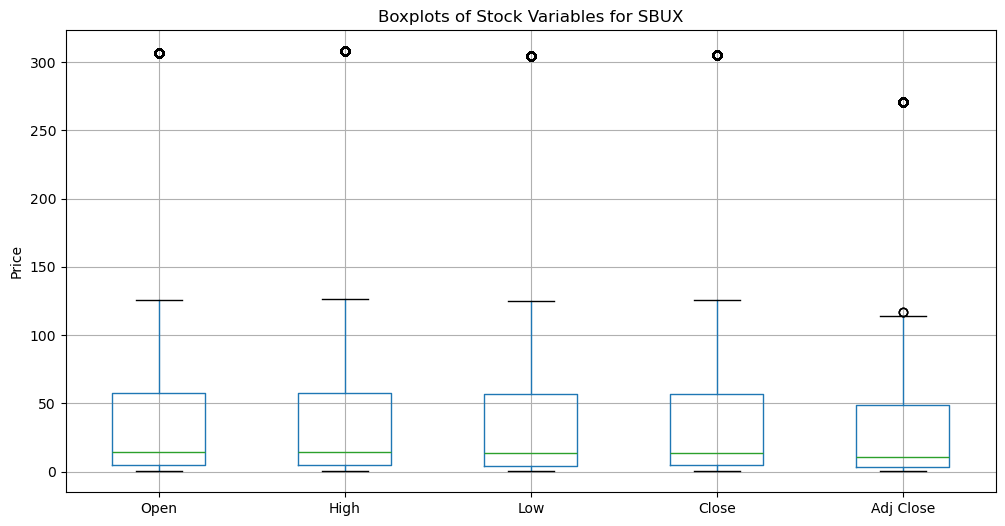

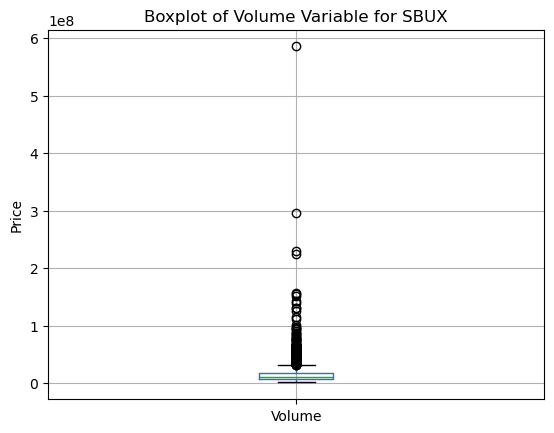

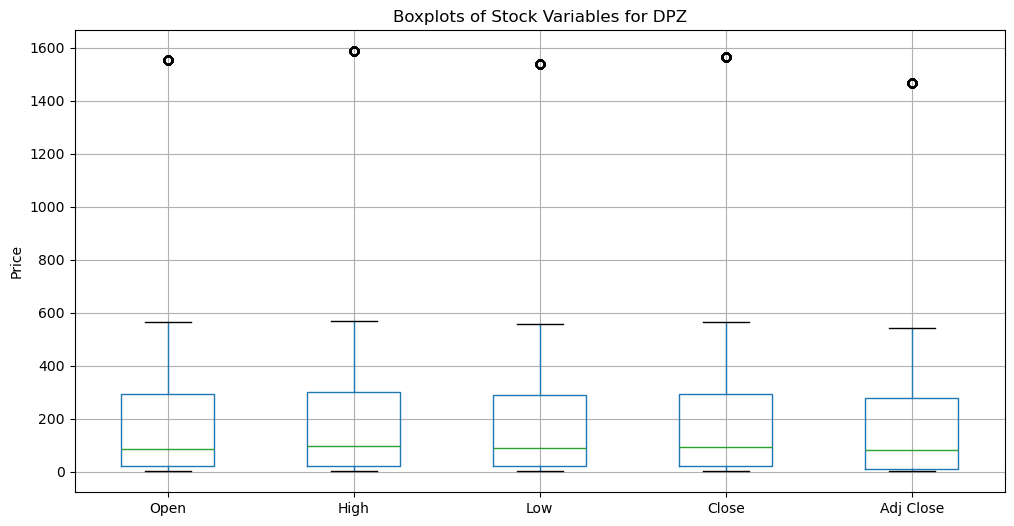

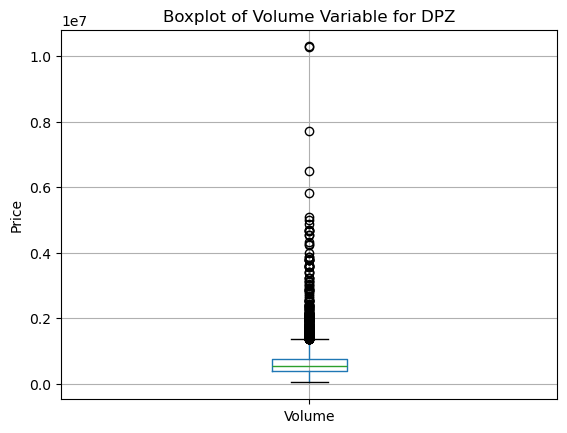

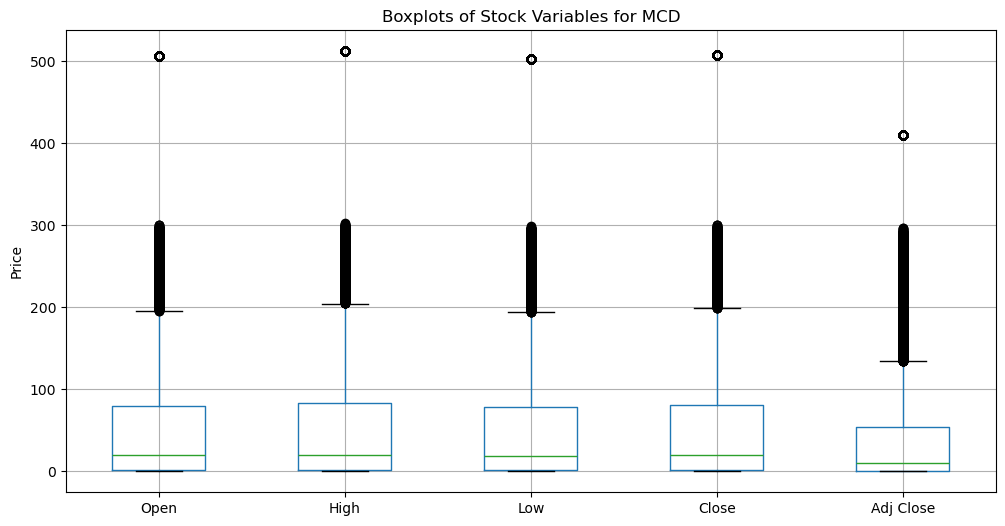

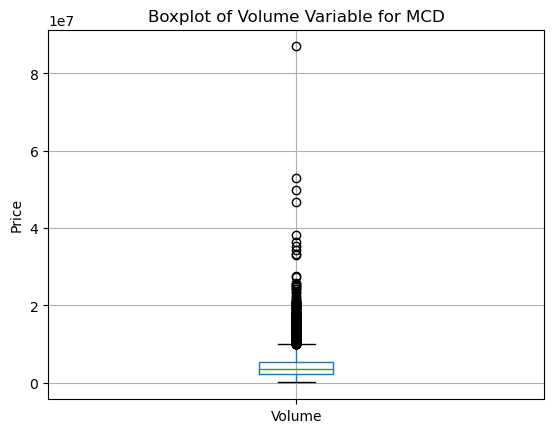

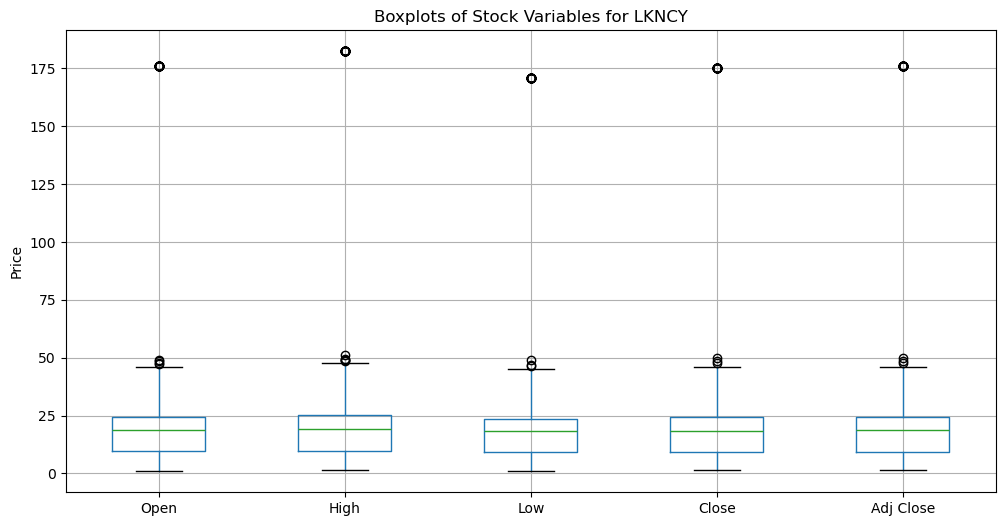

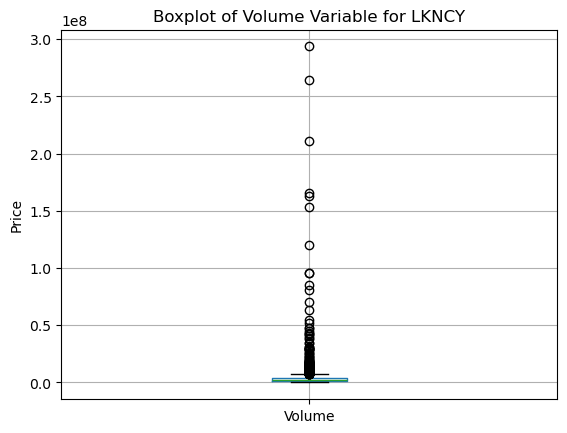

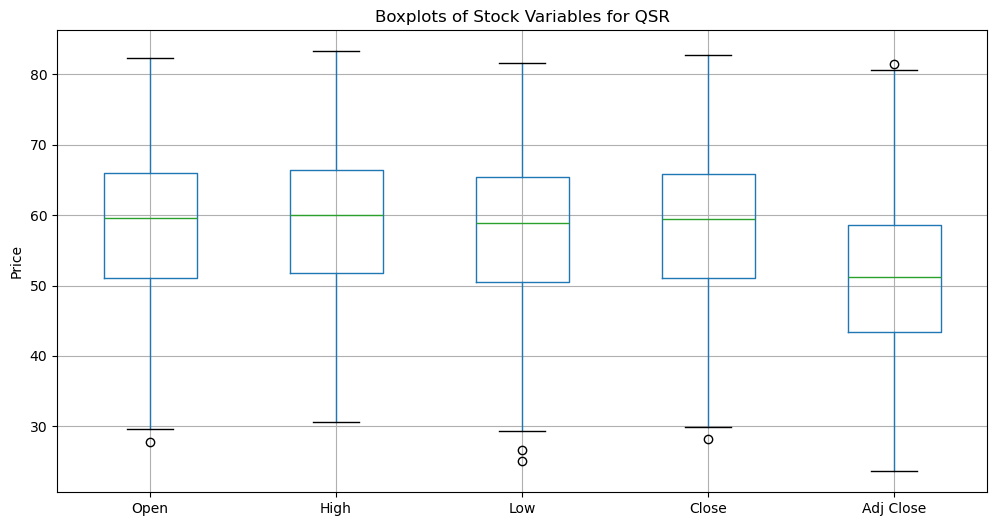

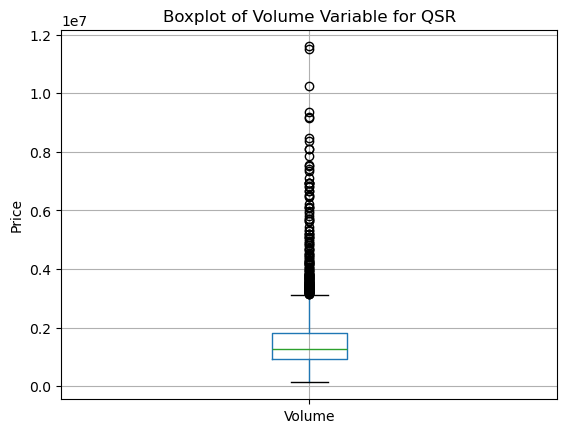

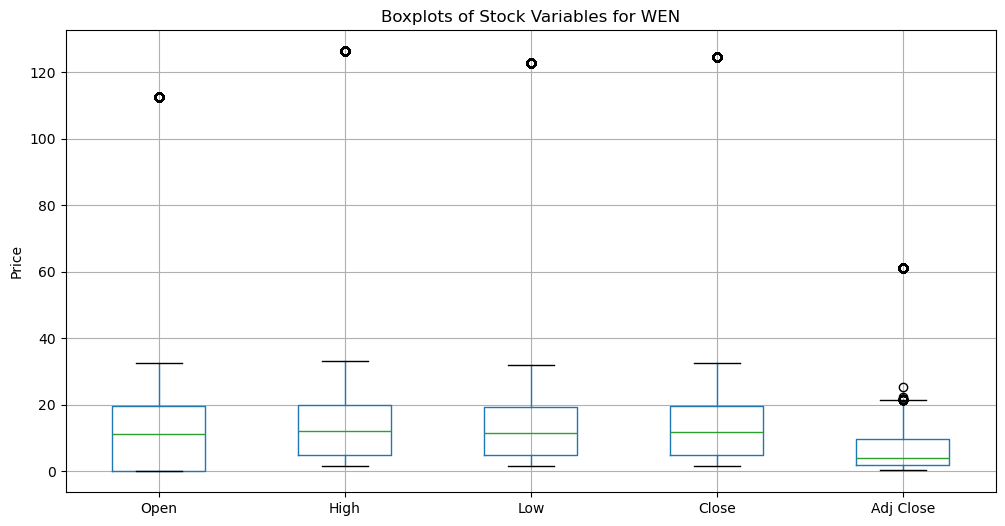

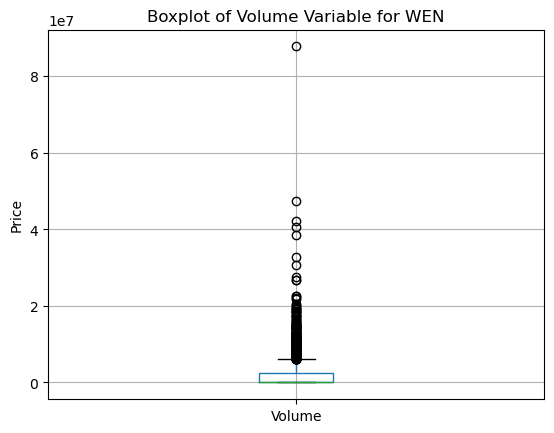

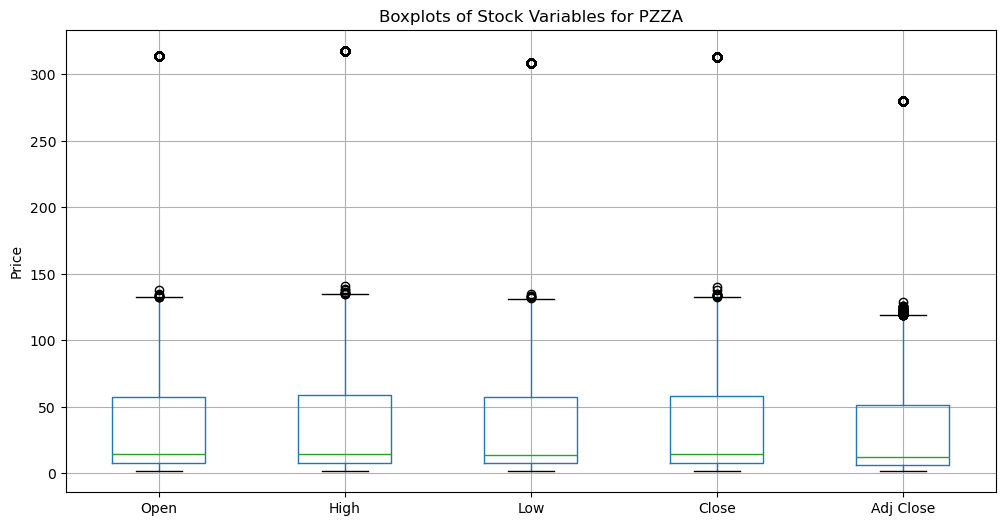

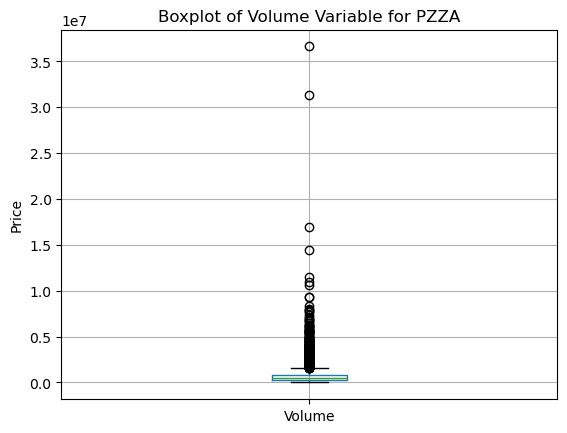

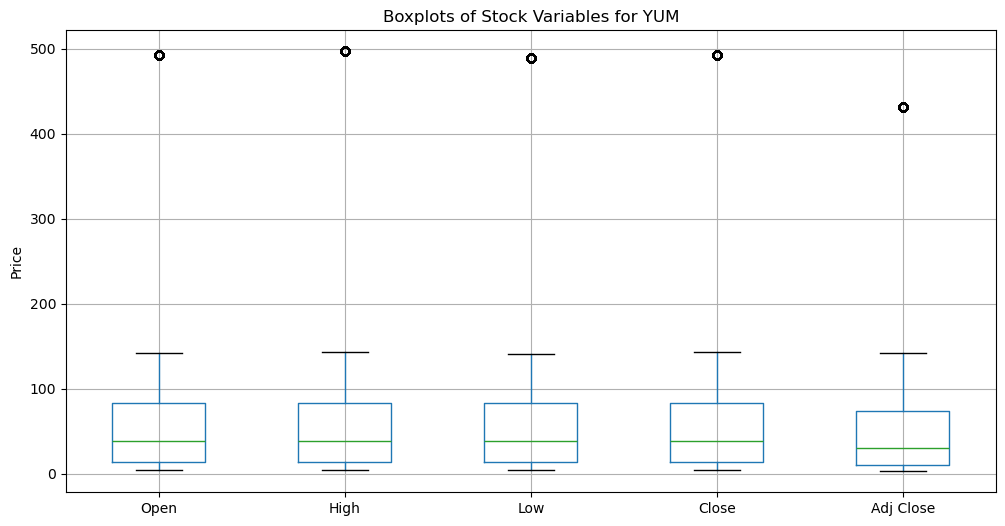

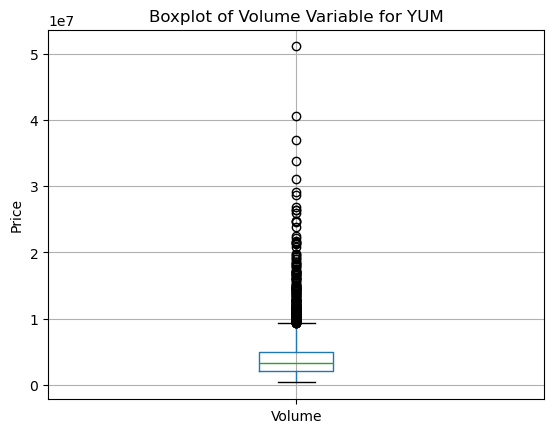

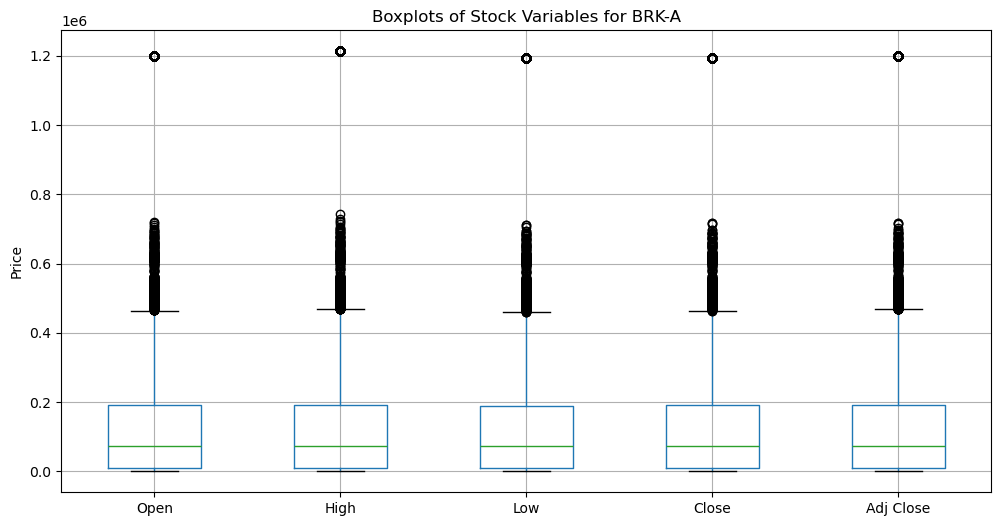

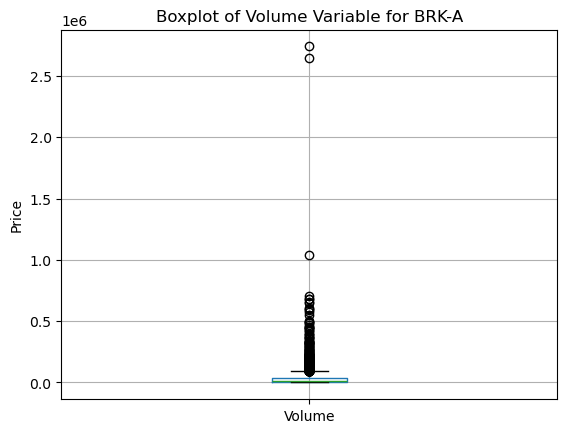

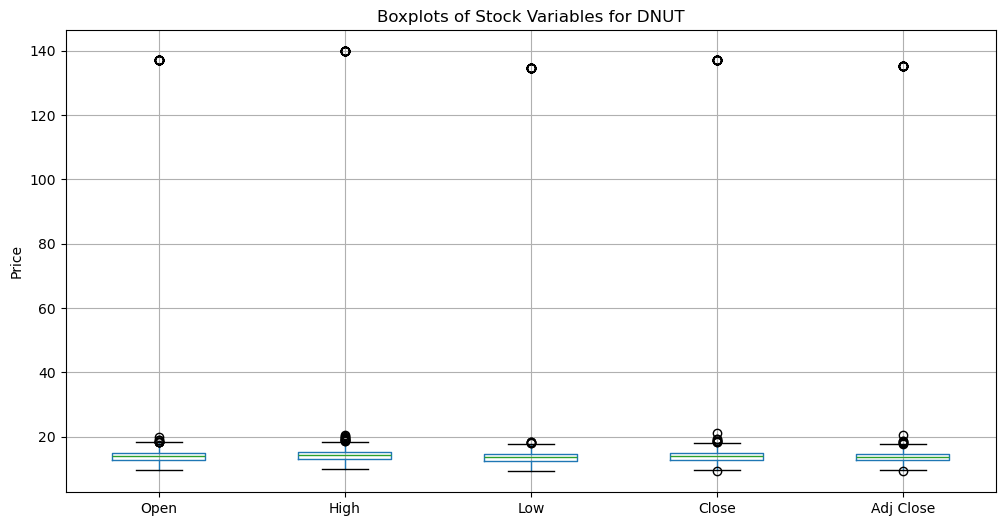

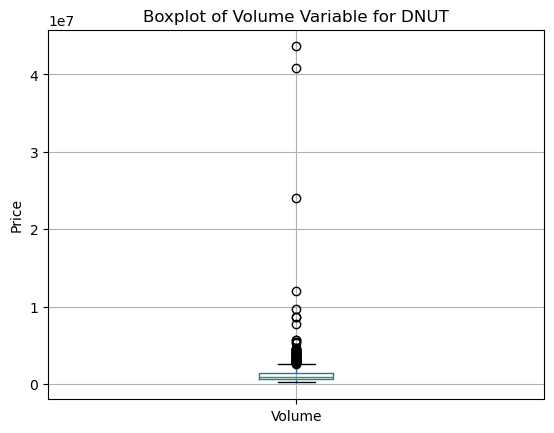

In [9]:
for df in dataframes:
    company_name = df["Company"][0]
    
    # Create a boxplot for each variable
    plt.figure(figsize=(12, 6))
    df[num_columns[:-1]].boxplot()
    plt.title(f"Boxplots of Stock Variables for {company_name}")
    plt.ylabel('Price')
    plt.grid(True, axis='y')
    plt.show()

    plt.figure()
    df[["Volume"]].boxplot()
    plt.title(f"Boxplot of Volume Variable for {company_name}")
    plt.ylabel('Price')
    plt.grid(True, axis='y')
    plt.show()

It can be observed that all datasets, except for the one from the company QSR, exhibit significant outliers. For the other nine companies, these outliers are located above the 75th percentile, falling into specific ranges considerably higher than this threshold.

To detect outliers and replace them with missing values, given the context of financial time series, we have opted for an approach utilizing sliding windows. The use of sliding windows in financial time series allows us to capture local trends and adapt to dynamic changes in the data, such as seasonal variations or periods of high volatility. This is achieved by using a sliding window (`rolling window`) to calculate the **local median** of each numeric column and comparing the current values to this central trend.

The criterion for identifying an outlier is based on the **relative change**, which measures how much a value deviates from the median relative to its magnitude. If the relative change exceeds a predefined threshold, the value is considered an outlier.

Process Steps
1. **Calculate the sliding median (`rolling_median`)**:
   - A sliding window of size `window_size` is used to calculate the median at each point in the time series.
   - The median is chosen instead of the mean because it is more robust to extreme values (outliers), preventing these values from affecting the central reference.

2. **Fill NaN values at the edges**:
   - Sliding windows produce `NaN` values at the edges of the series, so these are filled using forward (`bfill`) and backward (`ffill`) interpolations to maintain continuity.

3. **Calculate the relative change**:
   - The relative change is defined as:
     $$
     \text{Relative Change} = \frac{|x_t - \text{rolling\_median}|}{\text{rolling\_median}}
     $$
   - This value measures how far a point is from the local central trend.

4. **Identify outliers**:
   - A value is considered an outlier if its relative change exceeds a predefined threshold (`threshold`, e.g., 0.25 or 25%, making the detection highly sensitive).

5. **Replace outliers with `NaN`**:
   - Values identified as outliers are replaced with `NaN` in the DataFrame to prevent them from impacting future analyses.

In [10]:
window_size = 10
threshold = 0.25

for df in dataframes:
    print(df["Company"][0])
    print(f"Rows in {df["Company"][0]}: {df.shape[0]}")
    print(df.isnull().sum()) # Check for missing values

    for column in num_columns: #num_columns is the list of columns of each DataFrame we created earlier

        rolling_median = df[column].rolling(window=window_size, center=True).median()
        rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')

        relative_change = abs(df[column] - rolling_median) / rolling_median

        outliers = relative_change > threshold
        print(f"Outliers detected in {column}: {outliers.sum()}")

        df.loc[outliers, column] = np.nan

    print(df.isnull().sum())
    print("******************************************************************************")


SBUX
Rows in SBUX: 8122
Date           0
Open         394
High         393
Low          396
Close        402
Adj Close    396
Volume       406
Company        0
dtype: int64
Outliers detected in Open: 224
Outliers detected in High: 215
Outliers detected in Low: 251
Outliers detected in Close: 226
Outliers detected in Adj Close: 217
Outliers detected in Volume: 3034
Date            0
Open          618
High          608
Low           647
Close         628
Adj Close     613
Volume       3440
Company         0
dtype: int64
******************************************************************************
DPZ
Rows in DPZ: 5088
Date           0
Open         246
High         248
Low          249
Close        248
Adj Close    250
Volume       254
Company        0
dtype: int64
Outliers detected in Open: 148
Outliers detected in High: 137
Outliers detected in Low: 143
Outliers detected in Close: 132
Outliers detected in Adj Close: 140
Outliers detected in Volume: 2136
Date            0
Open          

/var/folders/7g/gn2kzw2d14qfpy5kj5m9tyfc0000gn/T/ipykernel_30977/95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/7g/gn2kzw2d14qfpy5kj5m9tyfc0000gn/T/ipykernel_30977/95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/7g/gn2kzw2d14qfpy5kj5m9tyfc0000gn/T/ipykernel_30977/95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/7g/gn2kzw2d14qfpy5kj5m9tyfc0000gn/T/ipykernel_30977/95997536.py:12: FutureWarning: Series.fillna with 'me

Outliers detected in Close: 296
Outliers detected in Adj Close: 308
Outliers detected in Volume: 6006
Date            0
Open          861
High          835
Low           871
Close         845
Adj Close     854
Volume       6565
Company         0
dtype: int64
******************************************************************************
PZZA
Rows in PZZA: 7883
Date           0
Open         375
High         381
Low          385
Close        386
Adj Close    383
Volume       394
Company        0
dtype: int64
Outliers detected in Open: 210
Outliers detected in High: 217
Outliers detected in Low: 206
Outliers detected in Close: 223
Outliers detected in Adj Close: 212
Outliers detected in Volume: 3863
Date            0
Open          585
High          598
Low           591
Close         609
Adj Close     595
Volume       4257
Company         0
dtype: int64
******************************************************************************
YUM
Rows in YUM: 6801
Date           0
Open         333
Hig

/var/folders/7g/gn2kzw2d14qfpy5kj5m9tyfc0000gn/T/ipykernel_30977/95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/7g/gn2kzw2d14qfpy5kj5m9tyfc0000gn/T/ipykernel_30977/95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/7g/gn2kzw2d14qfpy5kj5m9tyfc0000gn/T/ipykernel_30977/95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/var/folders/7g/gn2kzw2d14qfpy5kj5m9tyfc0000gn/T/ipykernel_30977/95997536.py:12: FutureWarning: Series.fillna with 'me

We can now check again the outliers present in the boxplots. We can observe how there considerably less outliers.

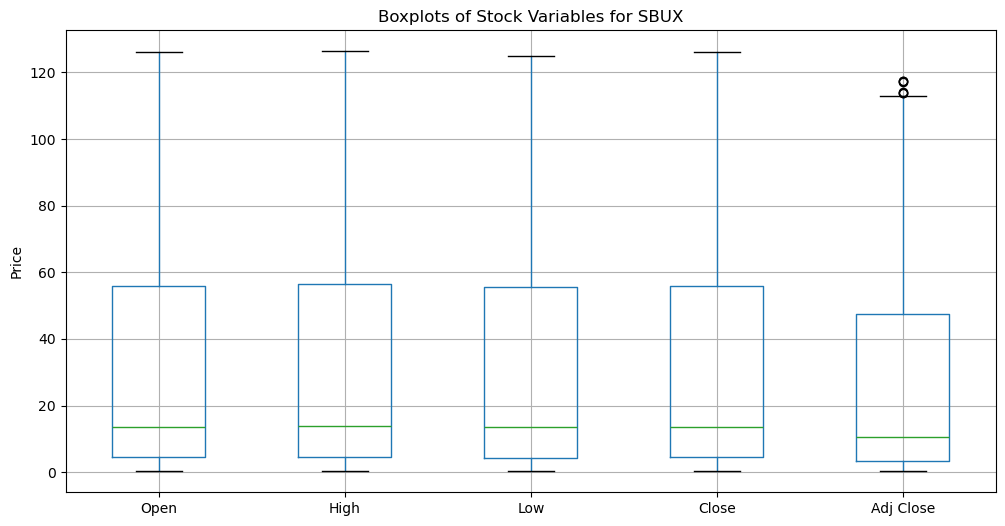

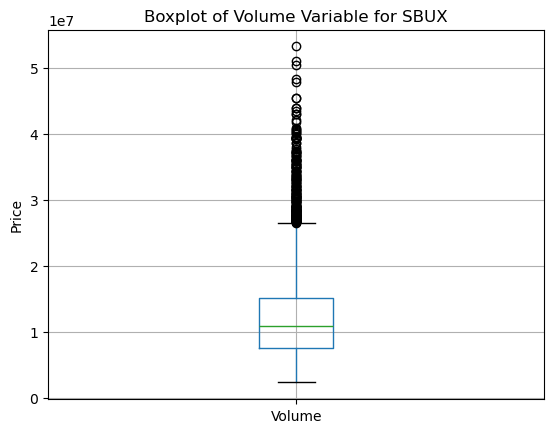

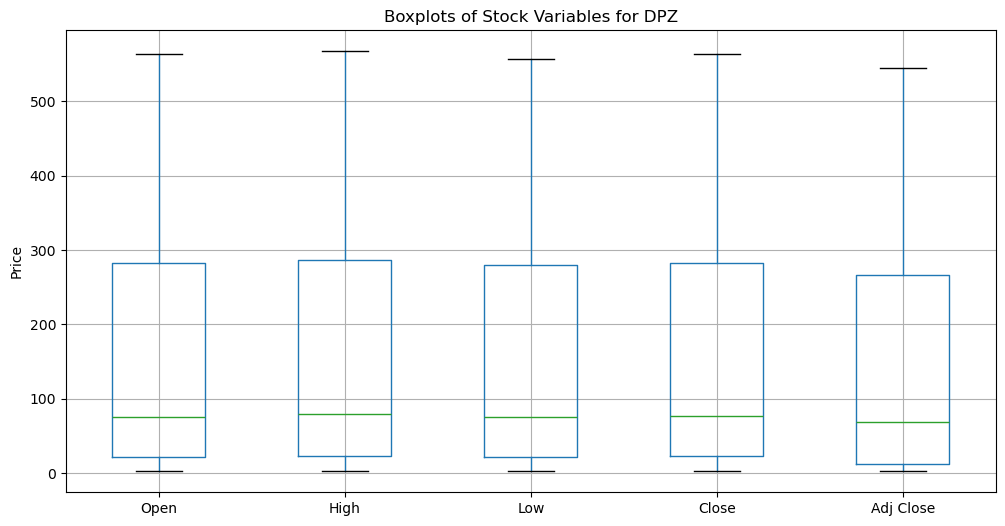

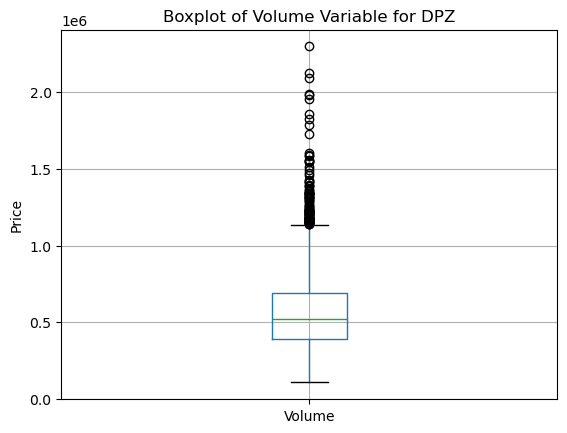

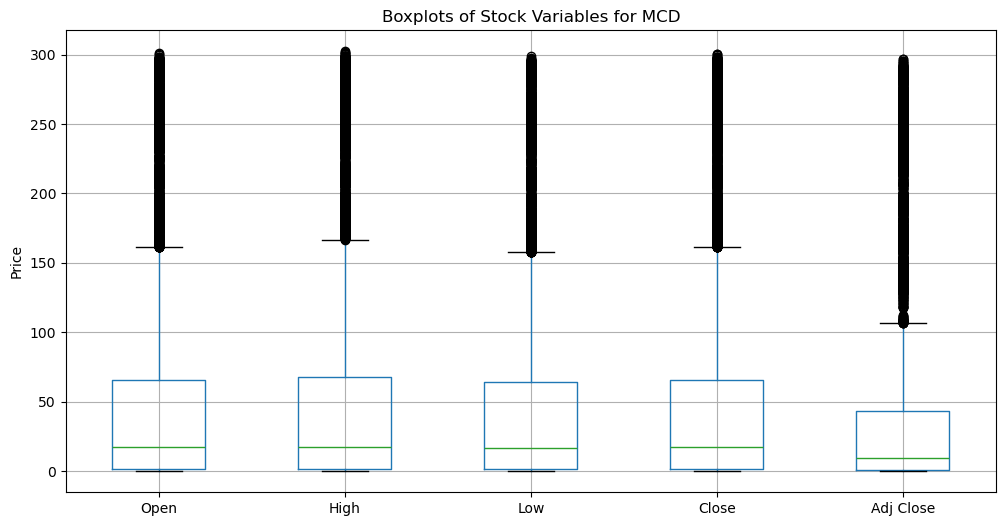

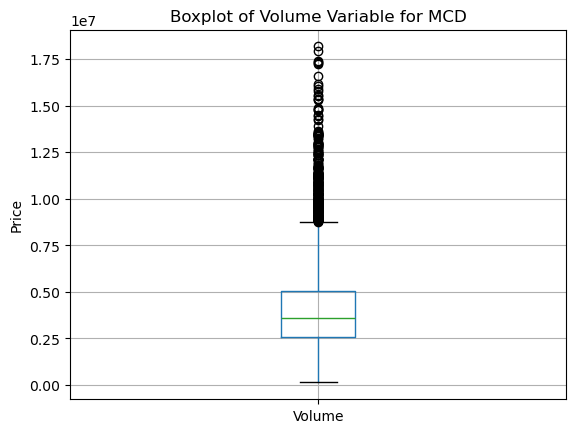

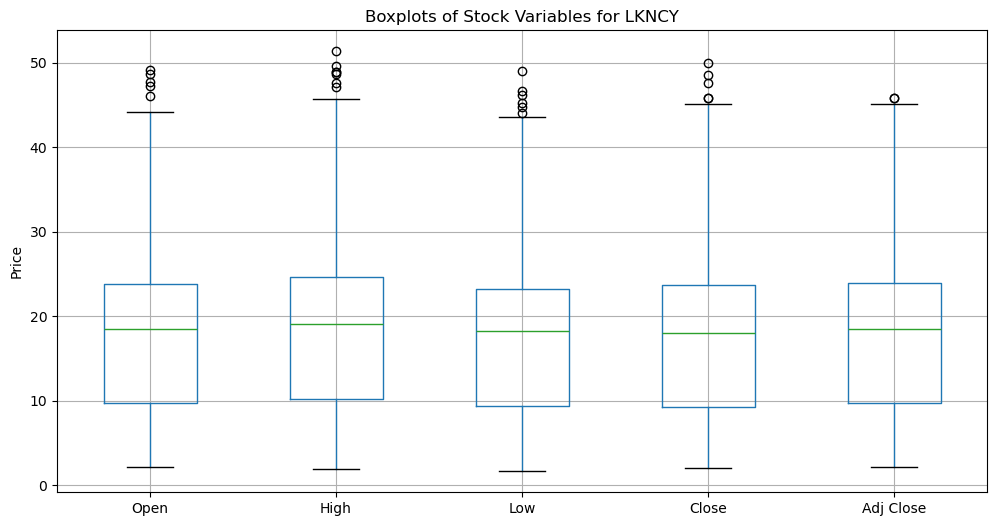

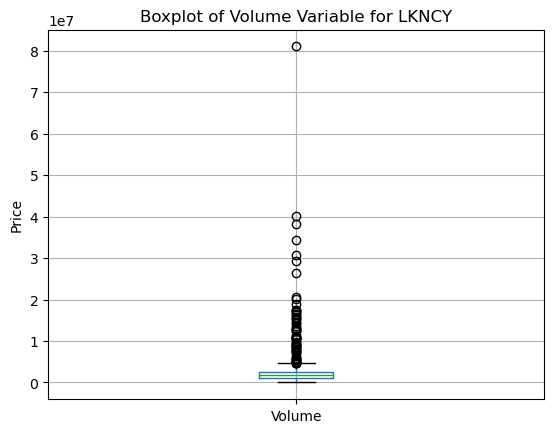

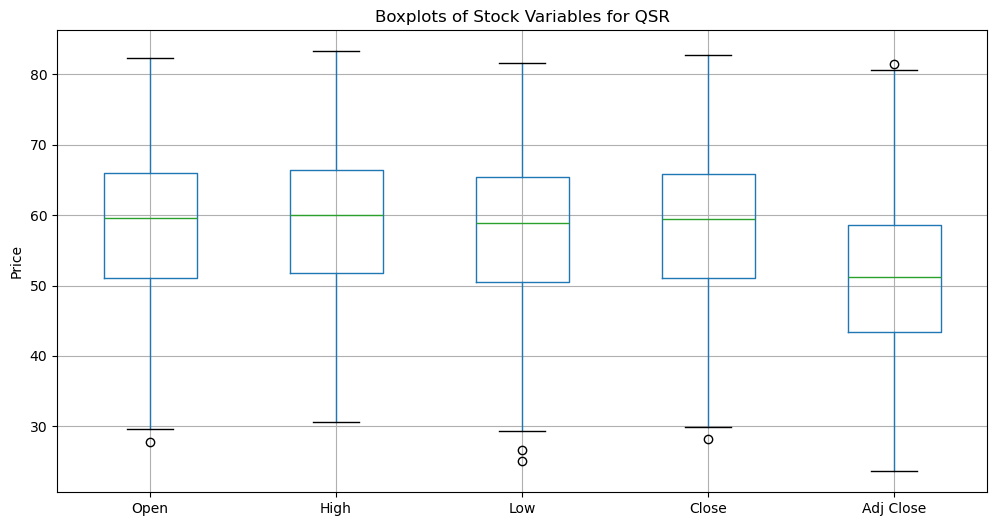

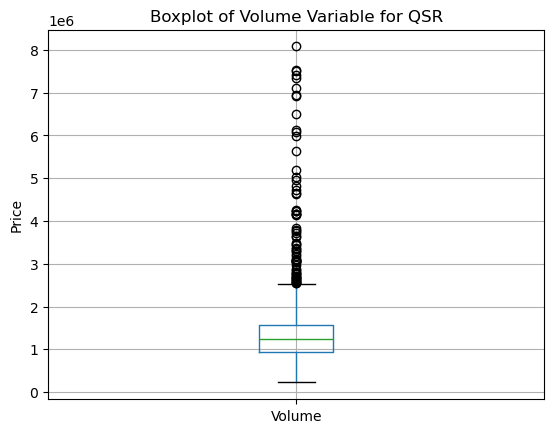

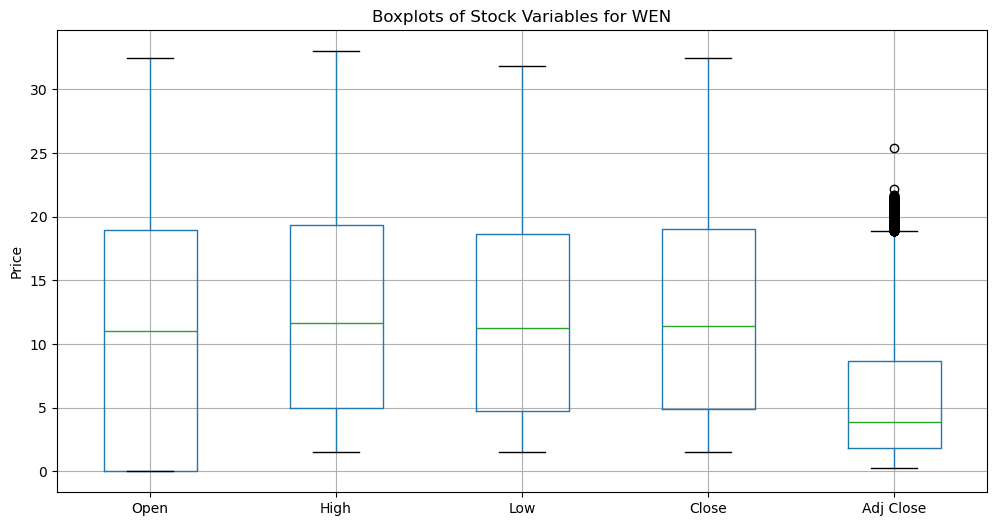

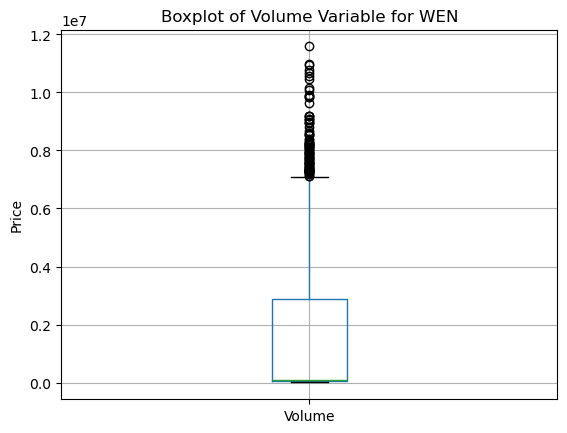

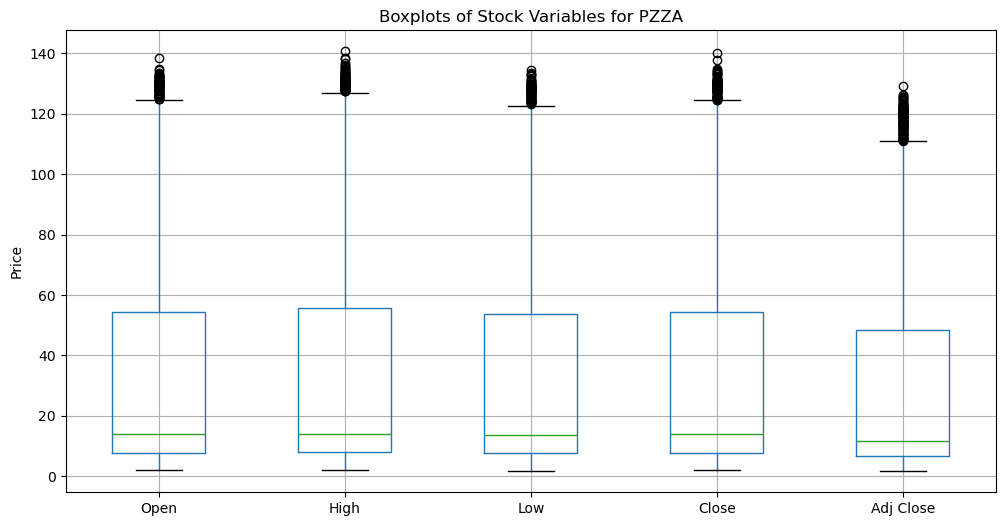

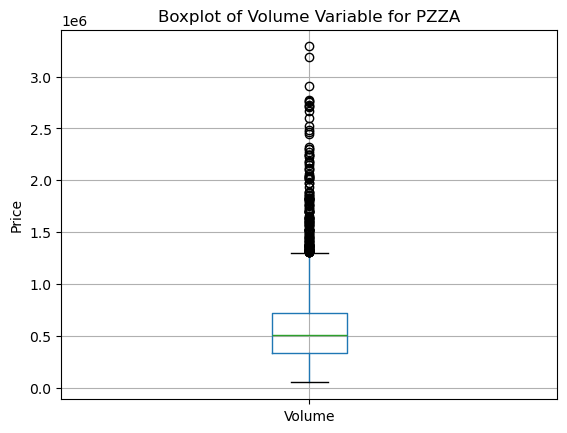

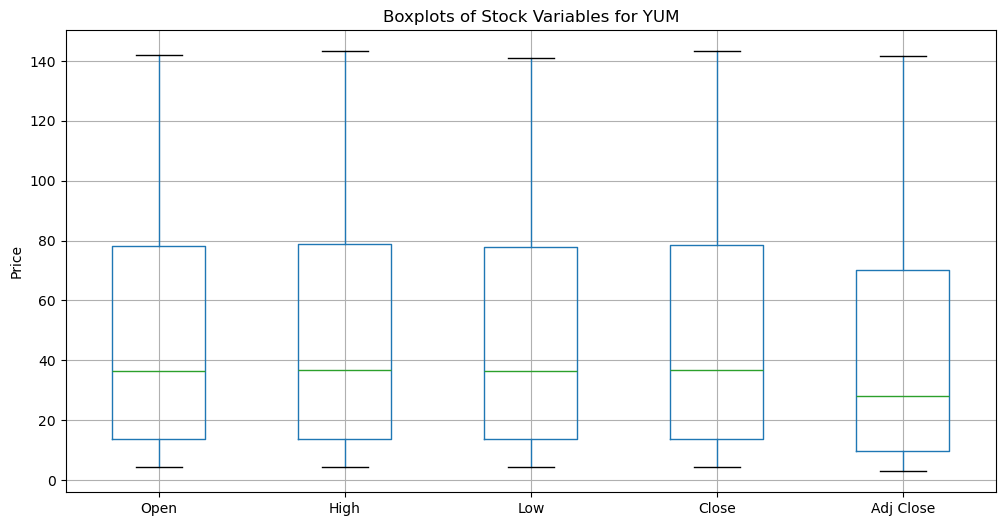

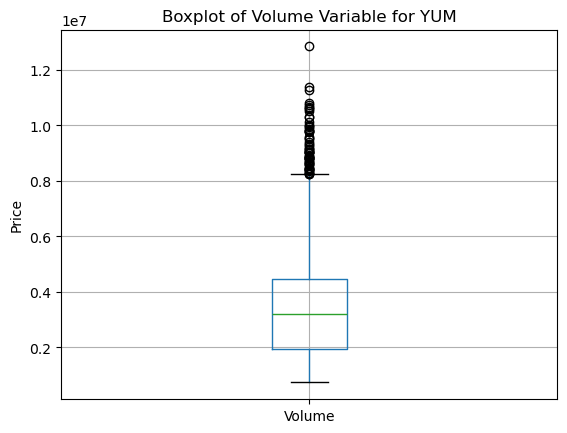

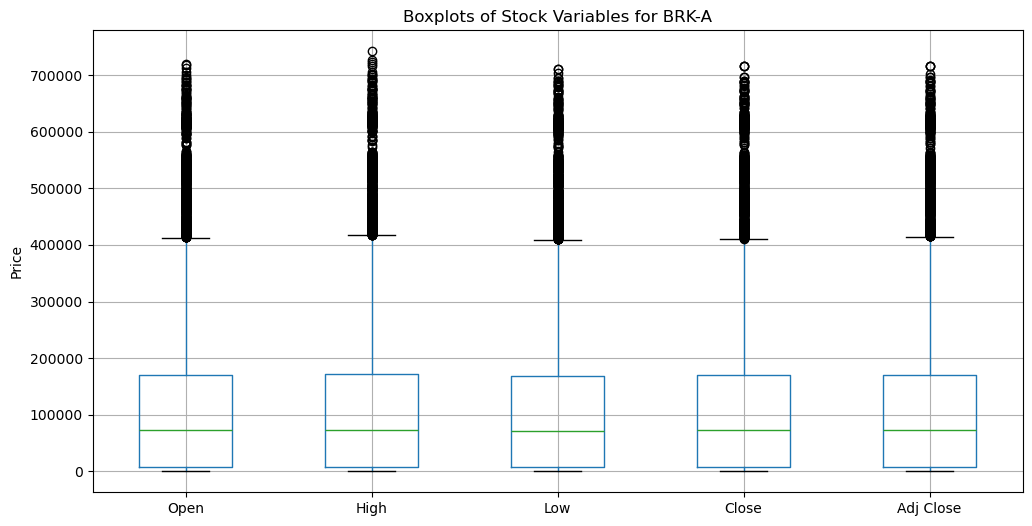

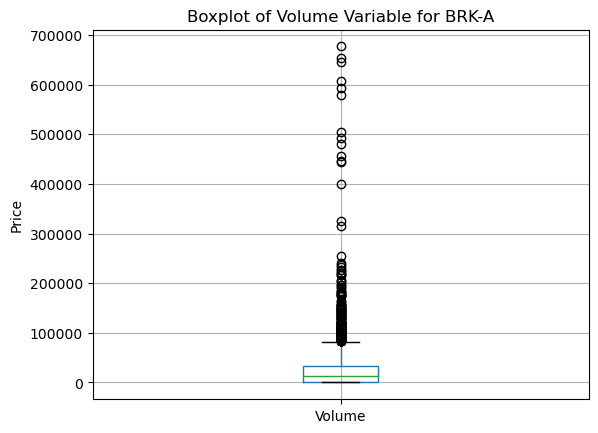

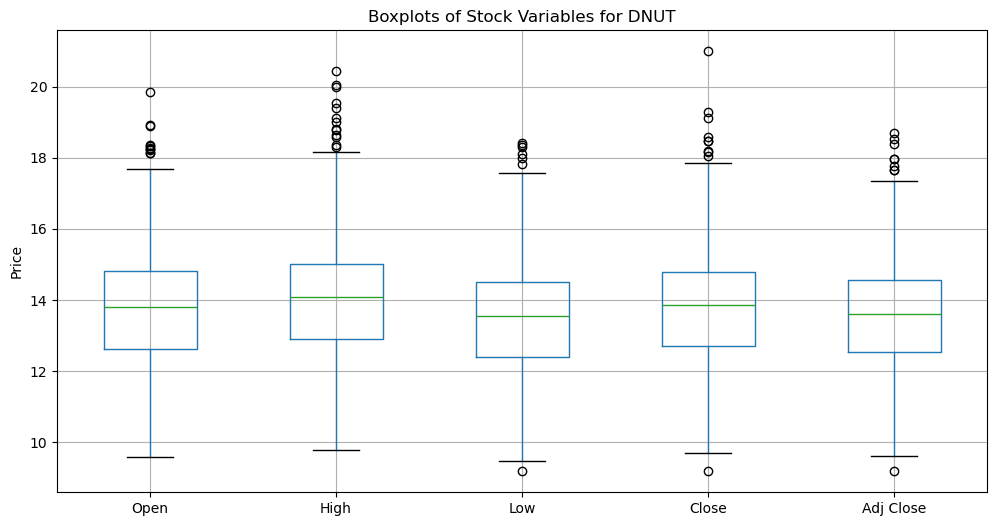

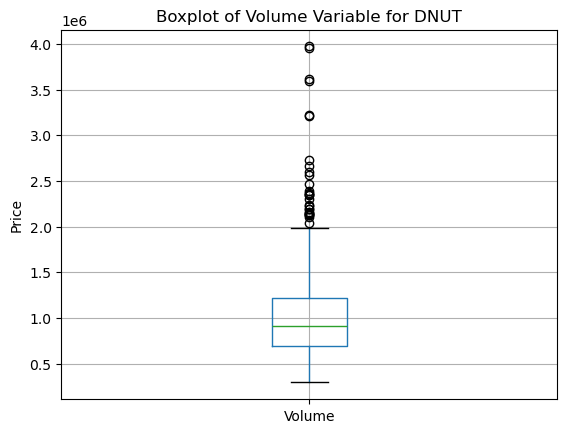

In [11]:
for df in dataframes:
    company_name = df["Company"][0]
    
    # Create a boxplot for each variable
    plt.figure(figsize=(12, 6))
    df[num_columns[:-1]].boxplot()
    plt.title(f"Boxplots of Stock Variables for {company_name}")
    plt.ylabel('Price')
    plt.grid(True, axis='y')
    plt.show()

    plt.figure()
    df[["Volume"]].boxplot()
    plt.title(f"Boxplot of Volume Variable for {company_name}")
    plt.ylabel('Price')
    plt.grid(True, axis='y')
    plt.show()

As we can also observe in the output of the cell where outliers were replaced with NaN values, this transformation has resulted in a large number of missing values for the "Volume" variable in each company. As shown in the following tables, the number of missing values for the "Volume" variable exceeds 50% of the observations in some cases.

In [12]:
results = []
company_names = []

for df in dataframes:
    company_name = df["Company"][0]
    company_names.append(company_name)
    total_rows = len(df)
    null_percentages = (df.isnull().sum() / total_rows) * 100
    
    result = {"Company": company_name}
    result.update(null_percentages.to_dict())
    results.append(result)

final_df = pd.DataFrame(results, index=company_names)
final_df = final_df.round(2)
final_df

,Company,Date,Open,High,Low,Close,Adj Close,Volume
SBUX,0.0,0.0,7.61,7.49,7.97,7.73,7.55,42.35
DPZ,0.0,0.0,7.74,7.57,7.70,7.47,7.67,46.97
MCD,0.0,0.0,7.59,7.42,7.44,7.35,7.46,45.94
LKNCY,0.0,0.0,10.22,11.04,9.93,10.59,10.59,57.41
QSR,0.0,0.0,0.00,0.00,0.00,0.00,0.00,38.51
WEN,0.0,0.0,7.69,7.46,7.78,7.55,7.63,58.66
PZZA,0.0,0.0,7.42,7.59,7.50,7.73,7.55,54.00
YUM,0.0,0.0,7.45,7.59,7.72,7.60,7.45,42.61
BRK-A,0.0,0.0,7.44,7.40,7.51,7.42,7.39,58.30
DNUT,0.0,0.0,7.73,8.47,9.94,7.73,7.61,41.84


In [13]:
for df in dataframes:
    print(df["Volume"].describe())

count    4.682000e+03
mean     1.245125e+07
std      6.704295e+06
min      2.380800e+06
25%      7.629350e+06
50%      1.087840e+07
75%      1.517245e+07
max      5.329600e+07
Name: Volume, dtype: float64
count    2.698000e+03
mean     5.707537e+05
std      2.583418e+05
min      1.062000e+05
25%      3.915000e+05
50%      5.180500e+05
75%      6.880000e+05
max      2.299200e+06
Name: Volume, dtype: float64
count    7.924000e+03
mean     4.054297e+06
std      2.223119e+06
min      1.336500e+05
25%      2.564775e+06
50%      3.590600e+06
75%      5.040250e+06
max      1.818580e+07
Name: Volume, dtype: float64
count    5.750000e+02
mean     3.149202e+06
std      5.555511e+06
min      0.000000e+00
25%      1.169250e+06
50%      1.761800e+06
75%      2.586800e+06
max      8.098610e+07
Name: Volume, dtype: float64
count    1.512000e+03
mean     1.377618e+06
std      7.988398e+05
min      2.242000e+05
25%      9.399750e+05
50%      1.237050e+06
75%      1.575975e+06
max      8.081600e+06
Name

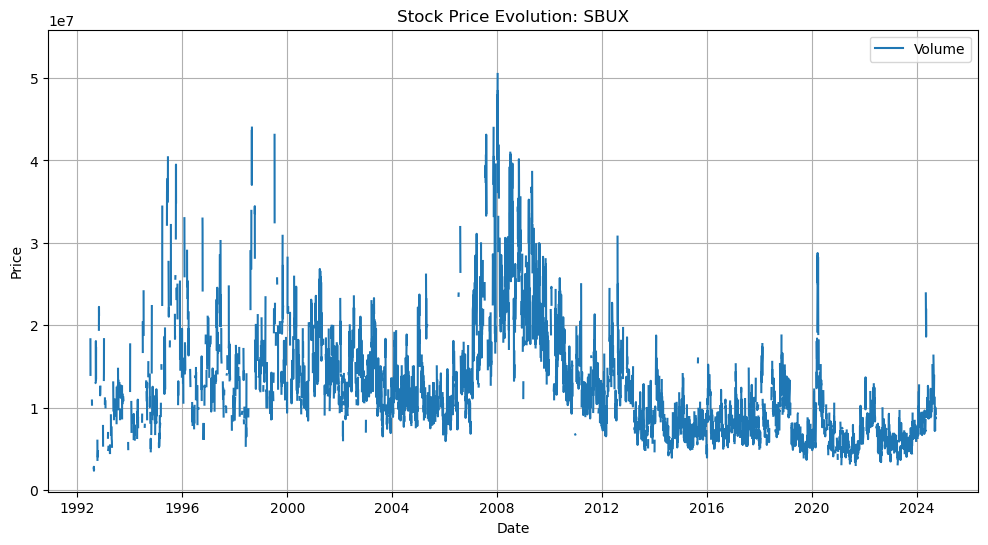

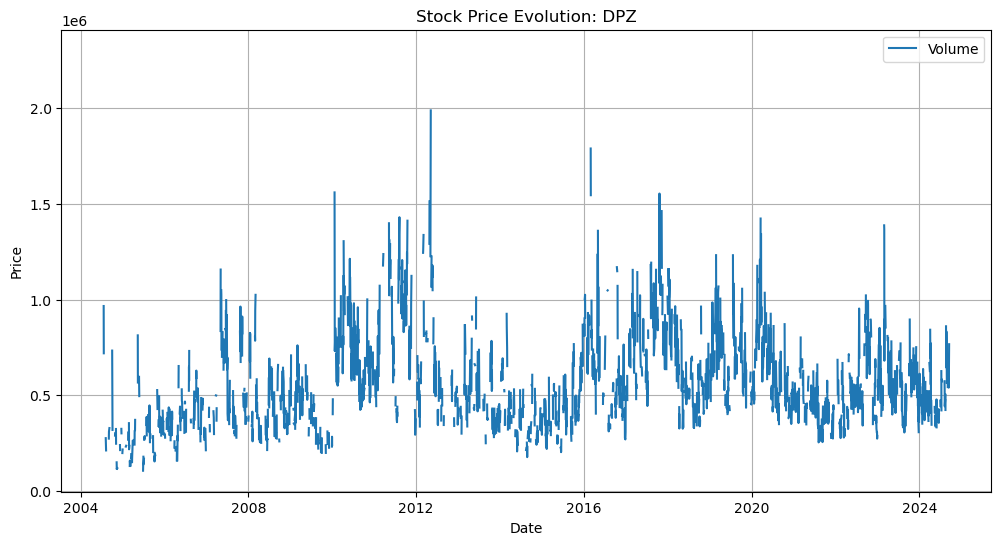

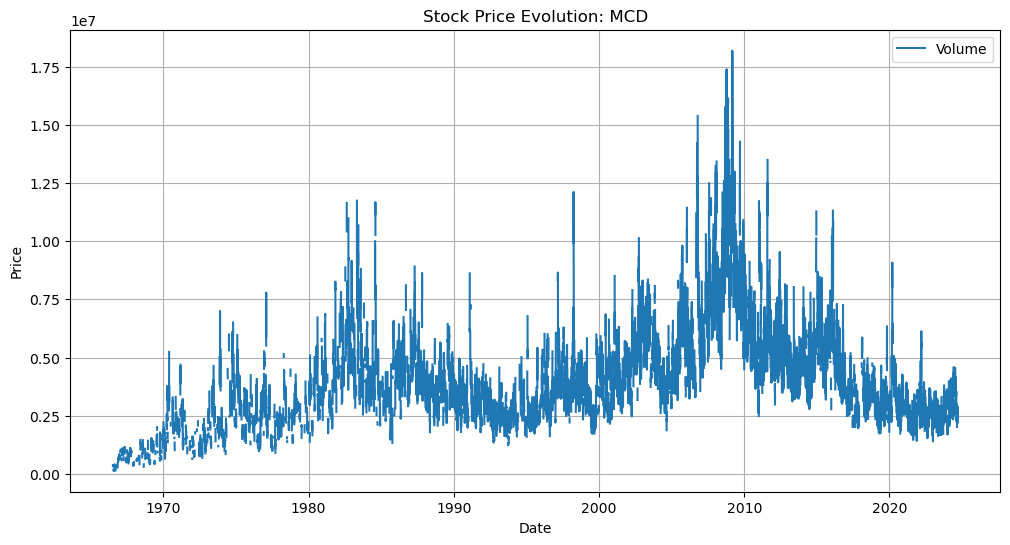

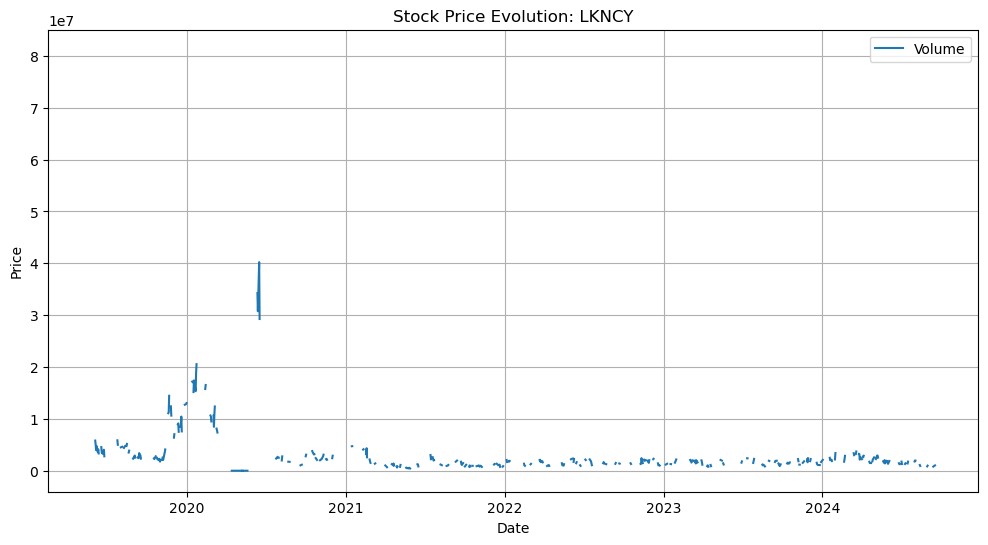

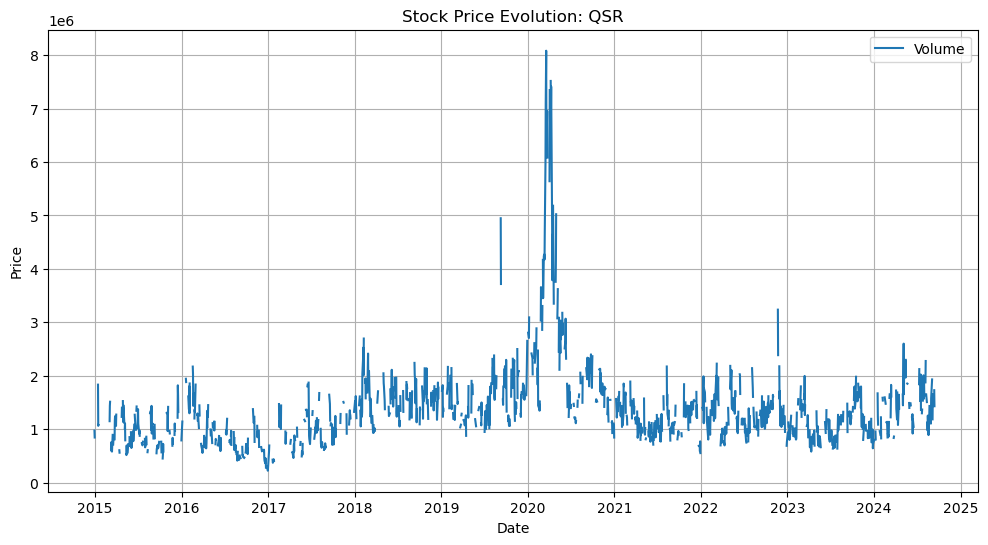

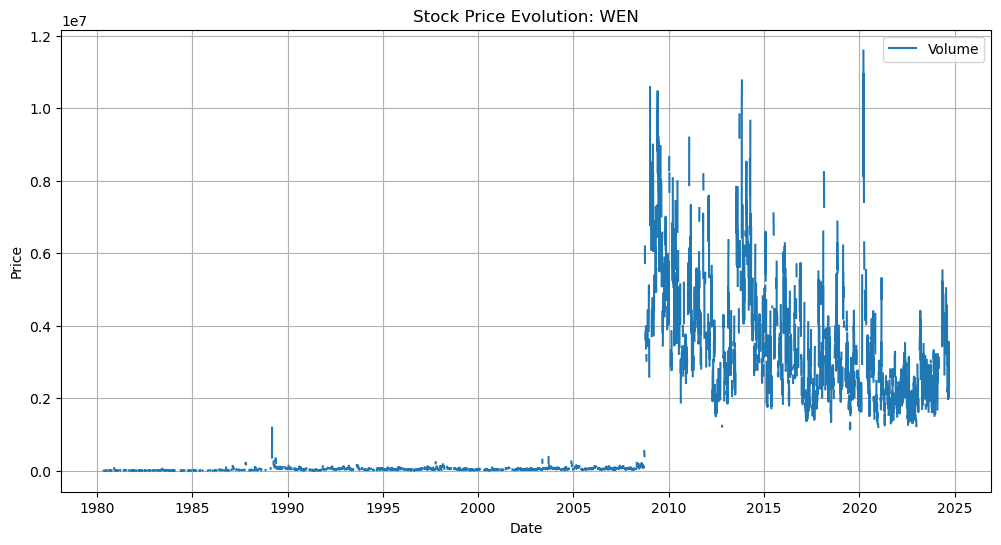

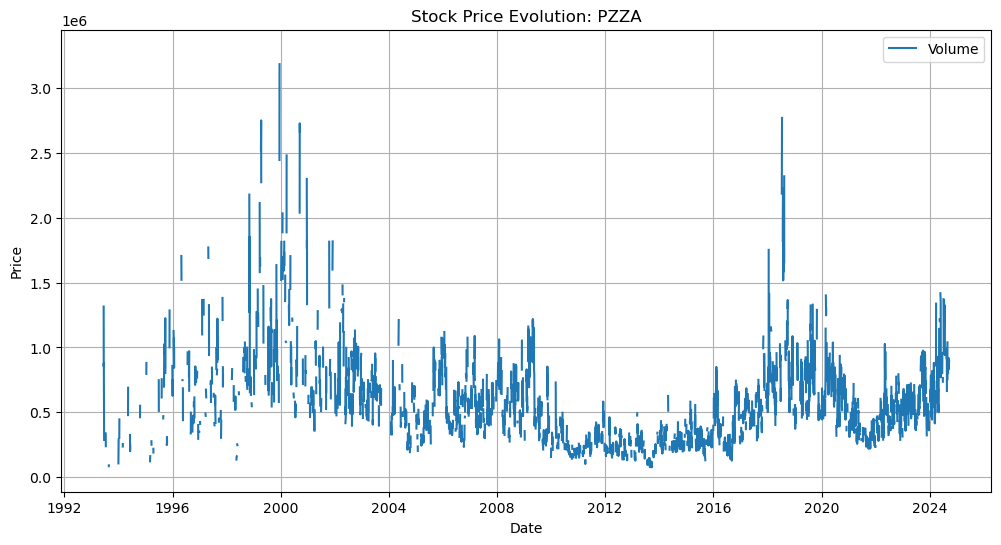

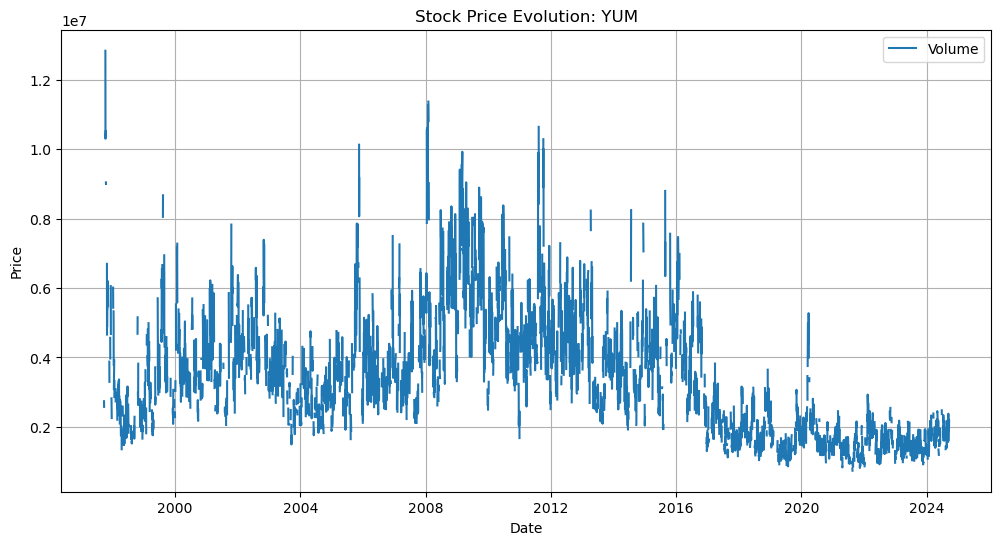

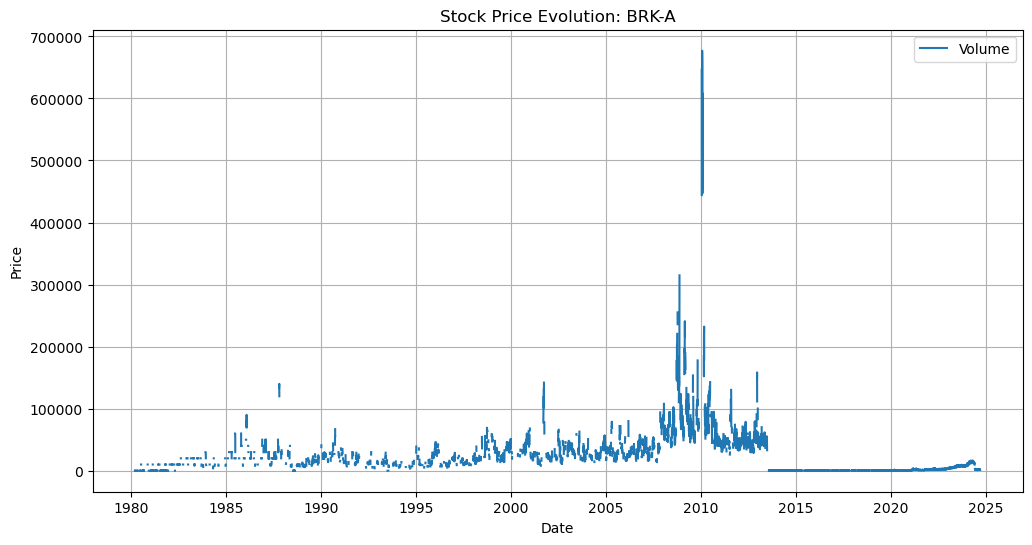

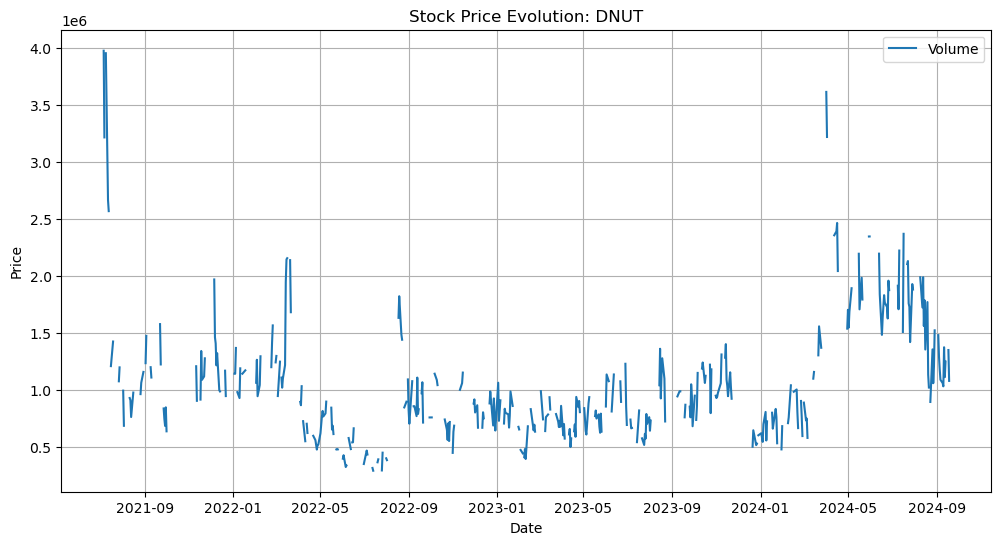

In [14]:
for df in dataframes:
    # Ensure the 'Date' column is parsed as datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort the data by date for proper plotting
    df.sort_values('Date', inplace=True)
    
    # Plot the line chart
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Volume'], label='Volume')
        
    # Chart formatting
    plt.title(f"Stock Price Evolution: {df["Company"][0]}")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Replace Missing Data

We used **interpolation** as the primary technique to replace missing values in the time series. Interpolation involves estimating the missing values based on adjacent known data, leveraging the continuity of the time series.

Interpolation Process
1. **Method Selection**:
   - We opted for **linear interpolation**, which assumes that data changes uniformly between the nearest known points.
   - This method is suitable for time series with smooth transitions and relatively stable patterns.

2. **Filling Missing Values**:
   - Each `NaN` value was estimated by calculating the slope between the nearest known points (previous and next) and assigning a proportional value within the interval.
   - For values at the start or end of the series, where sufficient data points were unavailable, forward and backward propagation methods were used as needed.

For the "Volume" variable, it was decided not to replace its missing values using any technique. In exercises where this variable is needed (7 and 8), the missing values will simply be discarded. We believe this approach is better than imputing values using any method, as it avoids introducing artificial values given the large proportion of missing data.

In [15]:
for df in dataframes:
    print(f"Procesando: {df['Company'][0]}")
    print("Valores NaN antes de la interpolación:")
    print(df.isnull().sum())

    for column in num_columns[:-1]:

        df[column] = df[column].interpolate(method='linear', limit_direction='both')

    print("Valores NaN después de la interpolación:")
    print(df.isnull().sum())
    print("******************************************************************************")


Procesando: SBUX
Valores NaN antes de la interpolación:
Date            0
Open          618
High          608
Low           647
Close         628
Adj Close     613
Volume       3440
Company         0
dtype: int64
Valores NaN después de la interpolación:
Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume       3440
Company         0
dtype: int64
******************************************************************************
Procesando: DPZ
Valores NaN antes de la interpolación:
Date            0
Open          394
High          385
Low           392
Close         380
Adj Close     390
Volume       2390
Company         0
dtype: int64
Valores NaN después de la interpolación:
Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume       2390
Company         0
dtype: int64
******************************************************************************
Procesando: MCD
Valor

Finally, we can observe the time series obtained for each dataset after the interpolation process.

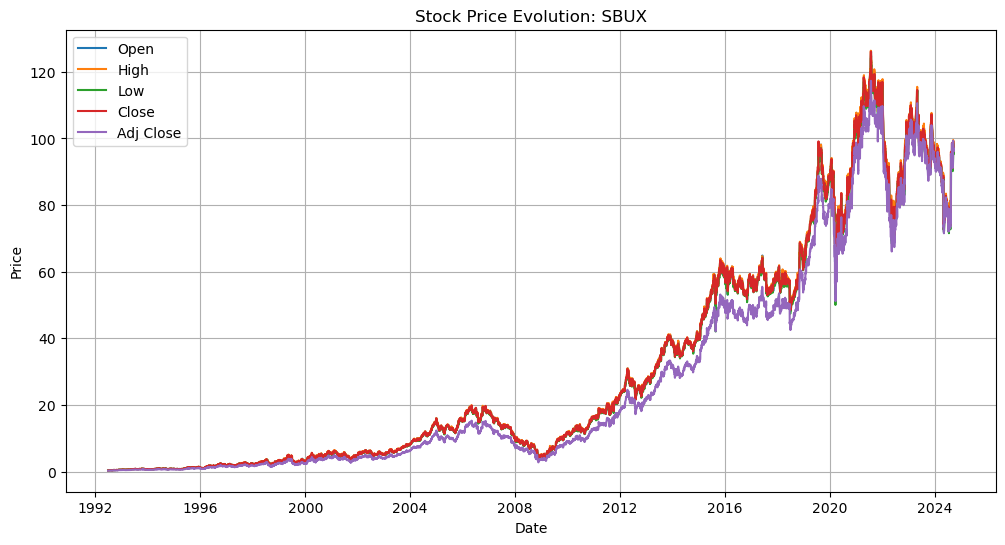

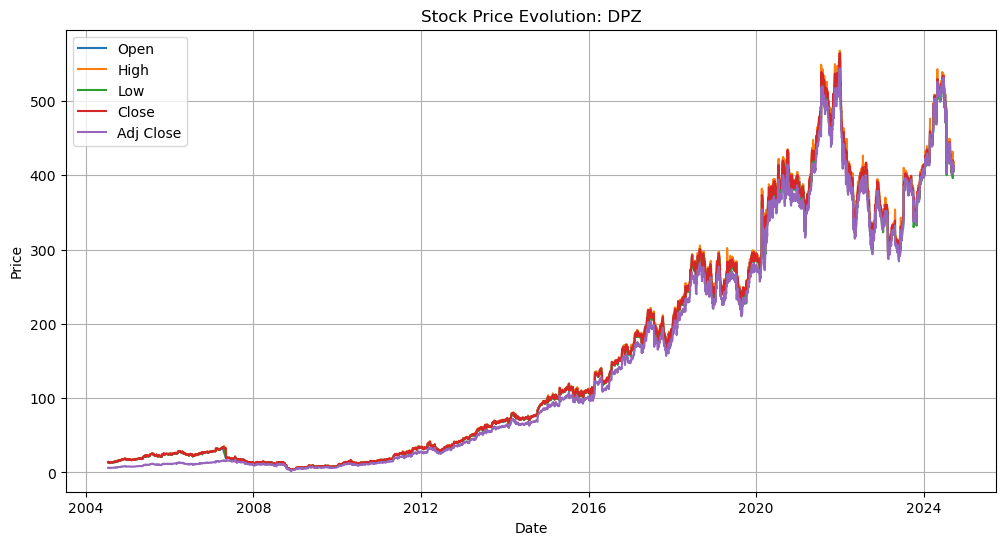

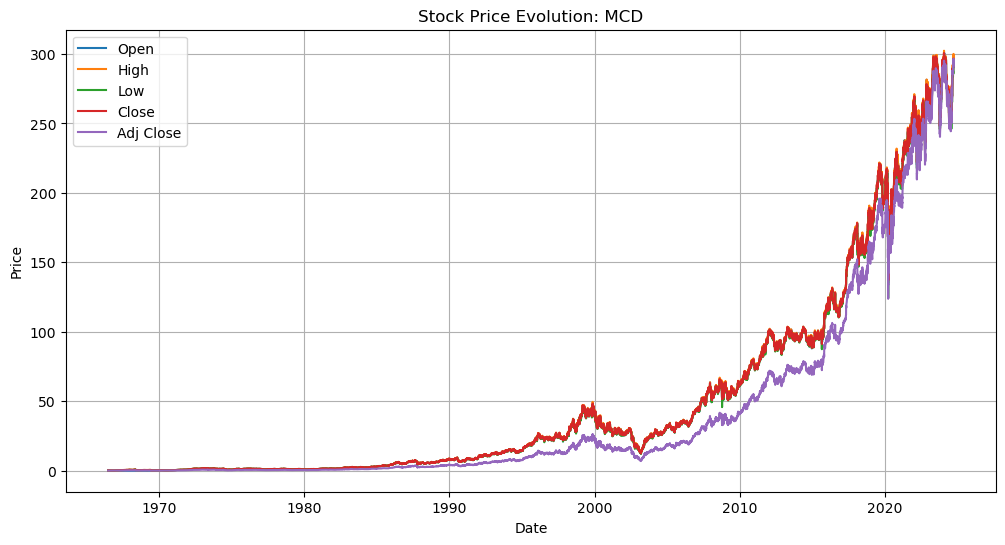

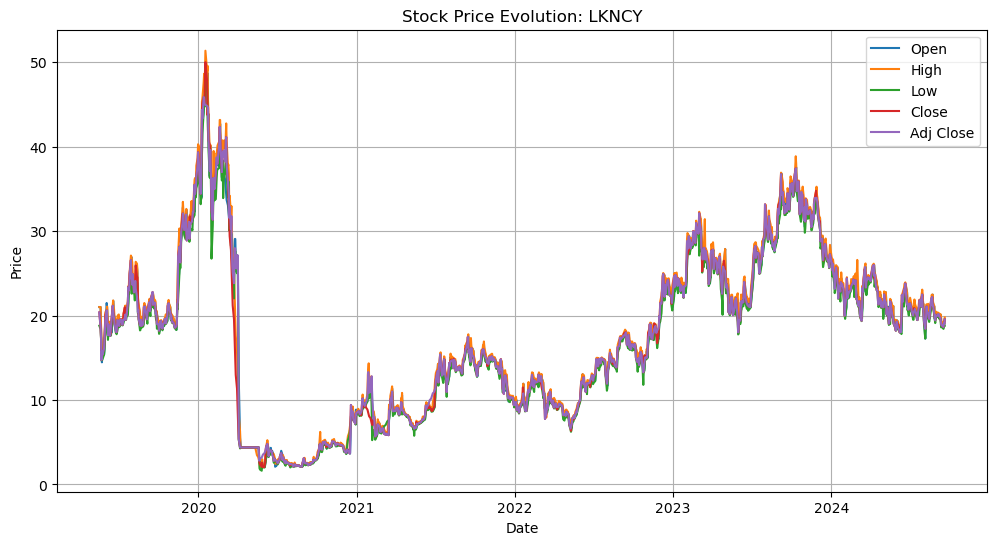

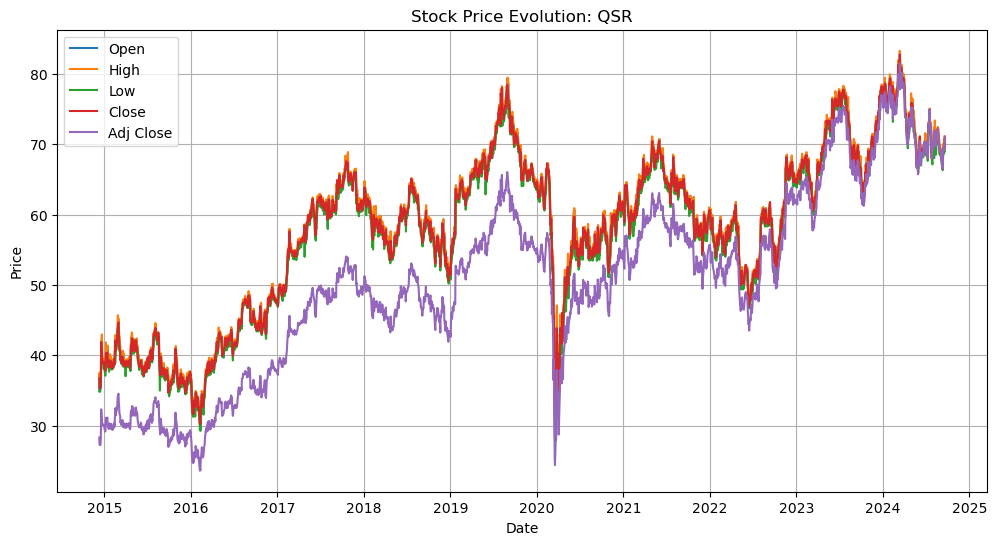

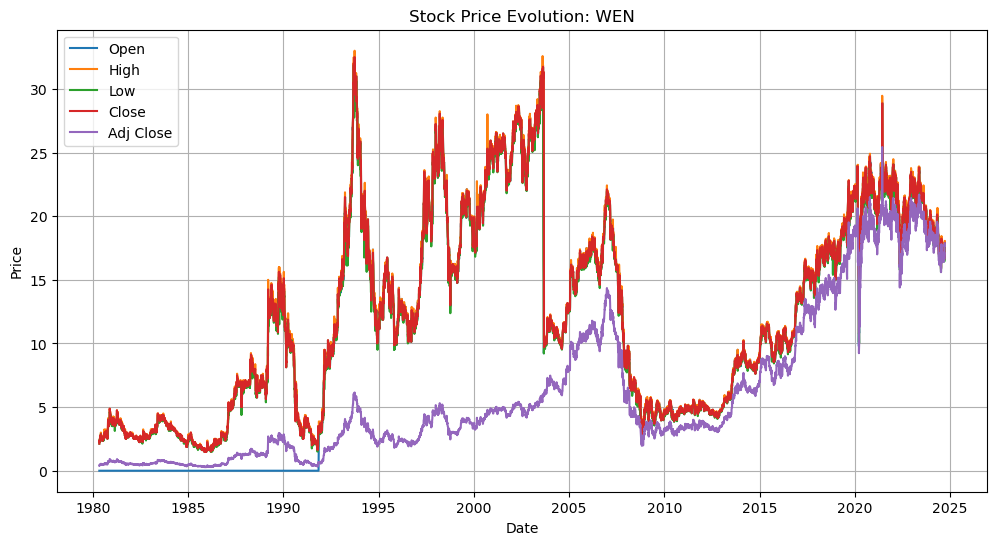

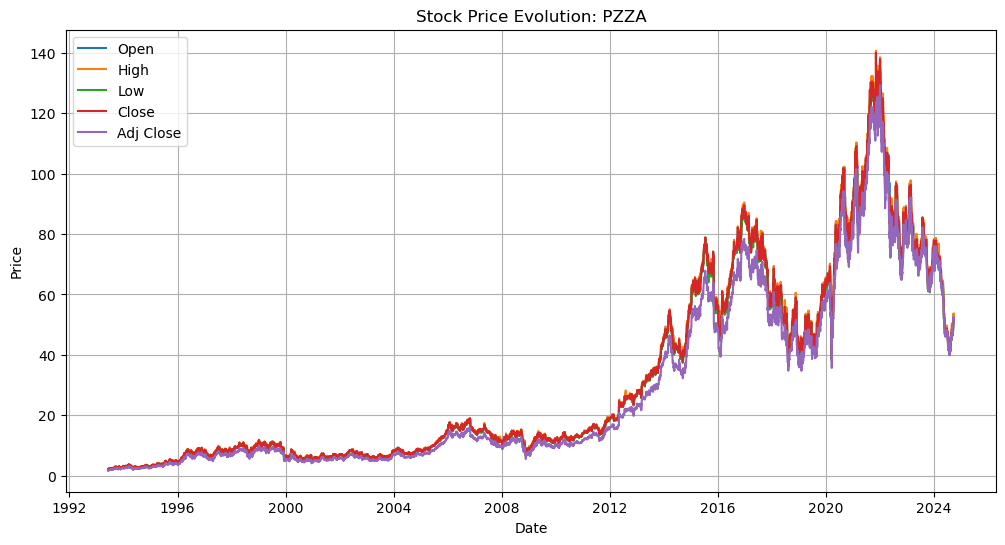

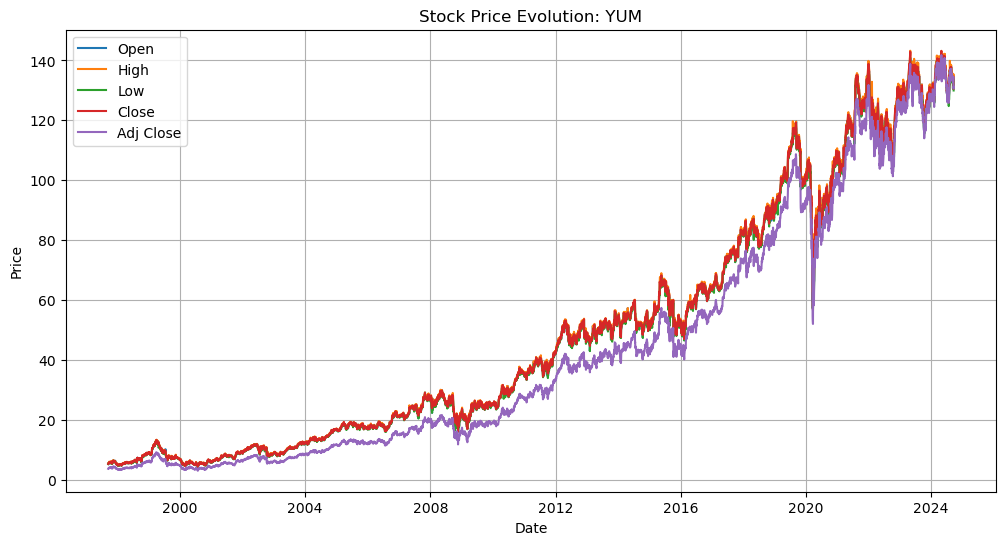

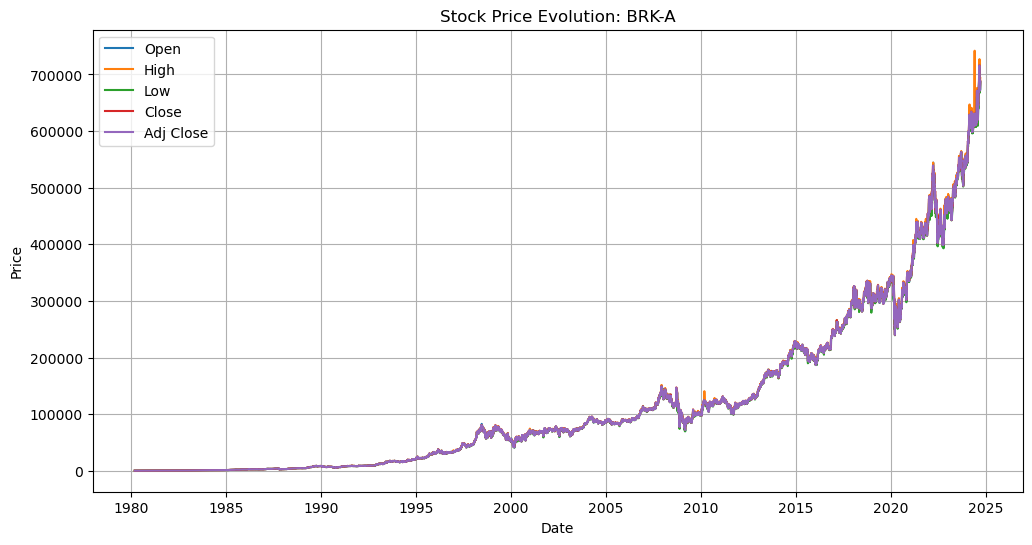

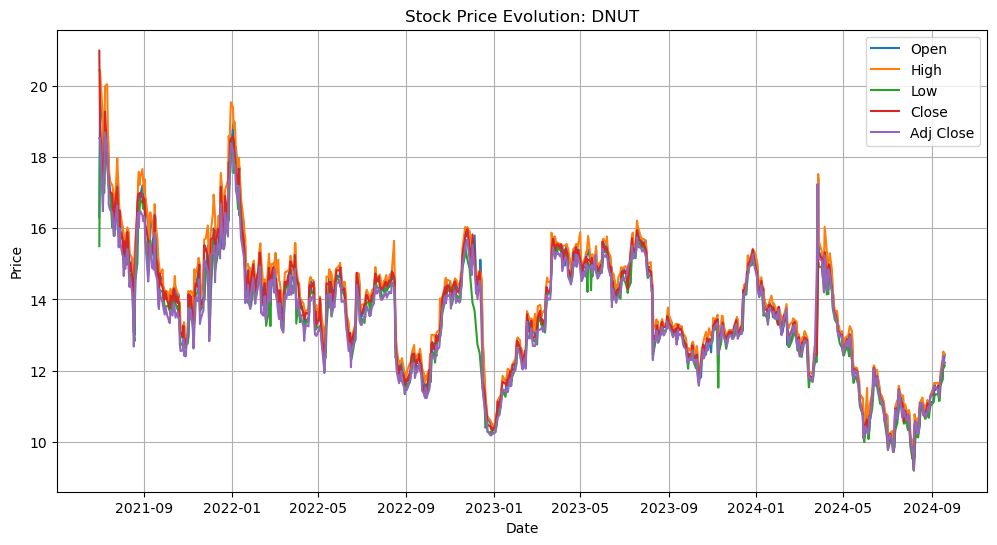

In [16]:
for df in dataframes:
    # Ensure the 'Date' column is parsed as datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort the data by date for proper plotting
    df.sort_values('Date', inplace=True)
    
    # Plot the line chart
    plt.figure(figsize=(12, 6))
    for variable in num_columns[:-1]:
        plt.plot(df["Date"], df[variable], label=variable)
    # plt.plot(df['Date'], df['Open'], label='Open')
    # plt.plot(df['Date'], df['High'], label='High')
    # plt.plot(df['Date'], df['Low'], label='Low')
    # plt.plot(df['Date'], df['Close'], label='Close')
    # plt.plot(df['Date'], df['Adj Close'], label='Adj Close')
    
    # Chart formatting
    plt.title(f"Stock Price Evolution: {df["Company"][0]}")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
results = []
company_names = []

for df in dataframes:
    company_name = df["Company"][0]
    company_names.append(company_name)
    total_rows = len(df)
    null_percentages = (df.isnull().sum() / total_rows) * 100
    
    result = {"Company": company_name}
    result.update(null_percentages.to_dict())
    results.append(result)

final_df = pd.DataFrame(results, index=company_names)
final_df = final_df.round(2)
final_df

,Company,Date,Open,High,Low,Close,Adj Close,Volume
SBUX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.35
DPZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.97
MCD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.94
LKNCY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.41
QSR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.51
WEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.66
PZZA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.00
YUM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.61
BRK-A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.30
DNUT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.84


### 1. For each dataset:
- Print the number of rows and columns.
- Display the column names and their data types.

In [18]:
# Iterate over files in the directory
for df in dataframes:
    # Print the dataset name
    print(f"{df["Company"][0]}:")
    # Print the shape of the DataFrame
    print(f"- Number of rows and columns: {df.shape}")
    # Print the column names
    print(f"- Columns: {list(df.columns)}")
    # Print the data types of each column
    print(f"- Data types:")
    print(df.dtypes)
    print("-" * 50)  # Separator for readability

SBUX:
- Number of rows and columns: (8122, 8)
- Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Company']
- Data types:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
Company              object
dtype: object
--------------------------------------------------
DPZ:
- Number of rows and columns: (5088, 8)
- Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Company']
- Data types:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
Company              object
dtype: object
--------------------------------------------------
MCD:
- Number of rows and columns: (14657, 8)
- Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Company']

### 2. Extract all rows where the date is in the year 2023.
- Print the number of rows.
- Visualize the `Close` price trend for this period.

In [19]:
for df in dataframes:
    company_name = df["Company"][0]
    df_2023 = df[df["Date"].dt.year == 2023]
    print(f"The number of observations for {company_name} for year 2023 is {df_2023.shape[0]}")

The number of observations for SBUX for year 2023 is 250
The number of observations for DPZ for year 2023 is 250
The number of observations for MCD for year 2023 is 250
The number of observations for LKNCY for year 2023 is 251
The number of observations for QSR for year 2023 is 250
The number of observations for WEN for year 2023 is 251
The number of observations for PZZA for year 2023 is 250
The number of observations for YUM for year 2023 is 250
The number of observations for BRK-A for year 2023 is 250
The number of observations for DNUT for year 2023 is 252


In [20]:
dfm["Date"] = pd.to_datetime(dfm["Date"], format="%Y-%m-%d")
dfm_2023 = dfm[dfm["Date"].dt.year == 2023]
print(f"The number of observations in the merged dataframe for year 2023 is {dfm_2023.shape[0]}")

The number of observations in the merged dataframe for year 2023 is 2504


### 3. For each company, find the day with the highest `Close` price.
- Display the date alongside the price.


In [36]:
# Dictionary to store results
results = {"Company": [], "Close": [], "Date": []}

for df in dataframes:
    # Extract the company name
    company_name = df["Company"].iloc[0]
    
    # Find the day with the highest Close price
    max_close_row = df.loc[df["Close"].idxmax()]
    max_date = max_close_row["Date"]
    max_close_price = max_close_row["Close"]
    
    # Append to results dictionary
    results["Company"].append(company_name)
    results["Close"].append(max_close_price)
    results["Date"].append(max_date)

# Display the results

results_df = pd.DataFrame(results)
print(results_df)



  Company          Close       Date
0    SBUX     126.059998 2021-07-26
1     DPZ     564.330017 2021-12-31
2     MCD     300.529999 2024-01-19
3   LKNCY      50.020000 2020-01-17
4     QSR      82.750000 2024-03-13
5     WEN      32.500000 1993-09-29
6    PZZA     140.009995 2021-11-04
7     YUM     143.190002 2024-04-29
8   BRK-A  715910.000000 2024-09-03
9    DNUT      21.000000 2021-07-01





---

### 4. Group the data by month and calculate the average `Close` price for each company.
- Plot these monthly averages for 3 companies and compare them.
- Justify the chart selection.

---

### 5. For each company:
- Compute the yearly average of the `Close` price.
- Plot a comparison of yearly averages for all companies on a chart.
- Justify your chart selection.

---

### 6. For each company, create a plot showing the range of prices for each month.
- Justify the chart selection.

---

### 7. Create a plot showing the relationship between trading volume and the `Close` price for a selected company.
- Add insights about the pattern and justify your chart selection.

---

### 8. For each company, identify the month with the highest total trading volume.
- Display the results in a summary table, showing the month and total volume.

---

### 9. Merge the datasets for all companies into a single dataset, one for each year.
- Print the structure of the combined dataset.
- Ensure proper alignment and handling of missing values.

---

### 10. For each company:
- Calculate the spread between the `High` and `Low` prices for each day.
- Calculate the average spread for each company and visualize the result in a chart.
- Justify the chart selection.
- Identify which companies exhibit the largest spreads and provide insights into their values.
